C:\Users\thivi\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\thivi\anaconda3\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\thivi\anaconda3\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


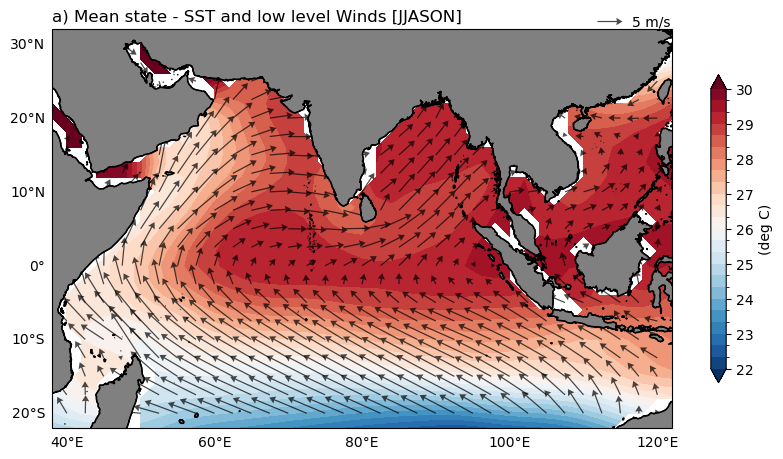

In [1]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

# Load SST data
fn = './sst.mnmean.nc'
data = xr.open_dataset(fn)
data = data.sel(time=slice('1997-09','2023-07'))
sst = data.sst
sst = sst.sel(lat=slice(32, -22))
sst = sst.sel(lon=slice(38, 122))

jjason = sst.sel(time=np.in1d(data['time.month'], [6, 7, 8, 9, 10, 11]))
clm = jjason.groupby('time.month').mean('time')
average_sst = clm.mean('month')

# Load wind data
fn1 = './surface_winds_ERA5.nc'
ds = xr.open_dataset(fn1)
ds = ds.sel(time=slice('1997-09', '2023-07'))
ds = ds.sel(latitude=slice(30, -20))
ds = ds.sel(longitude=slice(40, 120))

# Rename latitude and longitude coordinates
ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})

# Select a specific value for the expver dimension
ds = ds.isel(expver=0)
ds = ds.drop_vars('expver')

u = ds.u10
v = ds.v10

u_jjason = u.sel(time=np.in1d(u['time.month'], [6, 7, 8, 9, 10, 11]))
u_clm = u_jjason.groupby('time.month').mean('time')
u_average_chl = u_clm.mean('month')

v_jjason = v.sel(time=np.in1d(v['time.month'], [6, 7, 8, 9, 10, 11]))
v_clm = v_jjason.groupby('time.month').mean('time')
v_average_chl = v_clm.mean('month')

def plot_combined(ax, average_sst, ur, vr):
    # Plot SST contour
    contour = average_sst.plot.contourf(ax=ax, levels=25, extend='both', vmin=22, vmax=30, cmap='RdBu_r', 
                                        cbar_kwargs={'shrink': 0.5, 'aspect': 20, 'label': '(deg C)'})

    # Determine the dimensions of the u and v arrays
    n_dims = ur.shape

    # Create a grid of (x, y) coordinates matching the dimensions of u and v
    x, y = np.meshgrid(ur.lon, ur.lat)

    U = ur
    V = vr

    i = 10
    q = ax.quiver(x[::i, ::i], y[::i, ::i], U[::i, ::i], V[::i, ::i], color='k', alpha=0.7, headwidth=6, scale=20, scale_units='inches',
                  headlength=5, width=0.002, transform=ccrs.PlateCarree())

    # Add land features
    land = cfeature.NaturalEarthFeature(
        category='physical',
        name='land',
        scale='50m',
        facecolor=cfeature.COLORS['land']
    )
    ax.add_feature(land, edgecolor='black', facecolor='gray')

    # Add coastlines
    ax.coastlines(resolution='10m', linewidth=1)

    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.MultipleLocator(base=20)
    gl.ylocator = mticker.MultipleLocator(base=10)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    # Add a quiver key
    ax.quiverkey(q, X=0.92, Y=1.02, U=5, label='5 m/s', labelpos='E')

    # Set the title of the plot
    ax.set_title('a) Mean state - SST and low level Winds [JJASON]', loc='left')

# Create a Matplotlib figure and axis
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot combined SST and wind data
plot_combined(ax, average_sst, u_average_chl, v_average_chl)

# Show the plot
plt.show()
